## Group 5 讀書會2 以Netflix字詞分類

**Date created:** 2021/12/05<br>
**Last modified:** 2021/11/21<br>
本週的課程為「文件分類」主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分佈表示，再利用python的sklearn套件，套用SVC, linear regression等方式訓練模型，以分辨不同的文件。本次本小組將使用「中文」的文件分類，將PPT上Netflix的文章做戲劇（台劇、韓劇、陸劇）及情緒（正向、負向、中性）分類預測訓練。

## 大綱
1. 套件載入/資料載入
2. 文字前處理
    + 斷句
    + 斷詞（刪掉次數太少的、標點符號、停用字）
    + 算出情緒分數，將正負面文章分類
    + 將情緒標籤加回原本的資料集
    + 資料集基本檢視
3. 將資料分為測試集和訓練集
    + 根據7:3的比例切分資料集
4. 將文章轉為 DTM 放入模型訓練
    + 套入正式資料集訓練
    + 定義建模與畫圖的函數
5. 比較不同模型和資料組合的訓練結果
    + 包含戲劇及情緒兩者分析結果
    + SVC
    + Ramdomforest
    + Gradient Boosting
    + Xgboost
    + Catboost
    + Knn
    + 預測結果探索

## 分析目標
分析主題：將 ptt八卦版蒐集之文章，利用liwc字典計算情緒分數，依照戲劇分類為韓劇、陸劇、台劇，以及另外以分為正面、中性、負面三種標籤，用線性模型進行文件的情緒分類，希望分析可以獲得以下資訊：
+ 資料內容：
    + 資料來源：ptt KoreaDrama TaiwanDrama ChinaDrama版 (共1254筆)
    + 關鍵字:「Netflix」,「網飛」
    + 分類: 正面、中性、負面共三種標籤/ KoreaDrama TaiwanDrama ChinaDrama三種標籤

1. 字詞分部有甚麼不同，代表字詞有哪些？
    + 資料集基本檢視
    + 斷詞、詞性還原後檢視詞頻
    + 各字詞特徵的estimate係數
    + 利用建模後的estimate係數挑選各文集代表字
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 套入正式資料集訓練
    + 比較篩詞頻前後的DTM預測效果
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + 比較不同模型的ROC
    + 以不同模型的ROC比較準確率

In [51]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TransformerMixin
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor,XGBClassifier , XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


#### 載入資料

In [2]:
netflix_meta=pd.read_csv('netflix_articleMetaData.csv')
netflix_review=pd.read_csv('netflix_articleReviews.csv')
netflix_meta.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/01,07:55:24,https://www.ptt.cc/bbs/China-Drama/M.157786532...,sun8,China_Drama,2,0,0,"這段看的時候也不耐煩... 但是最後面解謎的時候，\n\n那種不耐感一掃而空,\n\n甚至格..."
1,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/01,16:18:28,https://www.ptt.cc/bbs/China-Drama/M.157789551...,niangniang,China_Drama,17,12,0,這部番外篇真的可有可無\n\n一開始在宣傳時很多人吐槽女兒看起來比媽媽老\n\n我也不懂為何...
2,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/02,13:42:53,https://www.ptt.cc/bbs/China-Drama/M.157797257...,keke0421,China_Drama,26,11,3,花了一個晚上看完\n\n結論就是 看不夠爽 但也心滿意足\n\n很可惜只有6集 沒有把9妹 ...
3,Re:[問題]weTV的vip付費問題,2020/01/27,18:37:24,https://www.ptt.cc/bbs/China-Drama/M.158015024...,Feishawn,China_Drama,4,2,0,推文裡面的其中一個狀況\n\n推 maxinehou: 電視盒版本跟網頁版本 vip好像不...
4,[閒聊]網劇《奈何boss要娶我2》先導預告！！！,2020/01/30,05:50:39,https://www.ptt.cc/bbs/China-Drama/M.158036344...,s7029,China_Drama,42,25,1,《奈何boss要娶我2》首發預告！！！\n\n由搜狐視頻和華晨美創聯合出品，\n\n「搜狐」...


In [3]:
print(f"number of posts: {netflix_meta.shape[0]}")
print(f"number of posts: {netflix_review.shape[0]}")

number of posts: 1254
number of posts: 243806


總共有1254篇文章，及243806筆評論留言

In [4]:
netflix_review.dropna(subset = ["cmtContent"], inplace=True)
netflix_meta['sentence'] = netflix_meta.sentence.apply(lambda x: re.sub('(完整內容|新聞|新聞網址|新聞來源|媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
netflix_meta['sentence'] = netflix_meta.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
netflix_meta['sentence'] = netflix_meta.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
netflix_review['cmtContent'] = netflix_review.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', str(x)))

Ngram建斷詞字典

In [30]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

#### Bigram

In [31]:
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [32]:
netflix_bigram_Meta = netflix_meta.copy()
netflix_bigram_Meta["word"] = netflix_bigram_Meta.sentence.apply(bigram_getToken)
netflix_bigram_Meta = netflix_bigram_Meta.explode('word')
netflix_bigram_Meta.head(3)
netflix_bigram_Meta_count = netflix_bigram_Meta.groupby(["word"],as_index=False).size()

Building prefix dict from /Users/yiiixian/Desktop/dict/dict.txt.big ...
Loading model from cache /var/folders/kk/hmwxhtss55ld73n__k3x5_k00000gn/T/jieba.u09d3ba750568d0785b9f1136434a24b6.cache
Loading model cost 1.440 seconds.
Prefix dict has been built successfully.


In [33]:
netflix_bigram_Reviews = netflix_review.copy()
netflix_bigram_Reviews["word"] = netflix_bigram_Reviews.cmtContent.apply(bigram_getToken)
netflix_bigram_Reviews = netflix_bigram_Reviews.explode('word')
netflix_bigram_Reviews.head(3)
netflix_bigram_Reviews_count = netflix_bigram_Reviews.groupby(["word"],as_index=False).size()

#### Trigram

In [34]:
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [35]:
netflix_trigram_Meta = netflix_meta.copy()
netflix_trigram_Meta["word"] = netflix_trigram_Meta.sentence.apply(trigram_getToken)
netflix_trigram_Meta = netflix_trigram_Meta.explode('word')
netflix_trigram_Meta.head(3)
netflix_trigram_Meta_count = netflix_trigram_Meta.groupby(["word"],as_index=False).size()

In [36]:
netflix_trigram_Reviews = netflix_review.copy()
netflix_trigram_Reviews["word"] = netflix_trigram_Reviews.cmtContent.apply(trigram_getToken)
netflix_trigram_Reviews = netflix_trigram_Reviews.explode('word')
netflix_trigram_Reviews.head(3)
netflix_trigram_Reviews_count = netflix_trigram_Reviews.groupby(["word"],as_index=False).size()

### 建模前資料處理

In [5]:
netflix_meta=pd.read_csv('netflix_articleMetaData.csv')
netflix_review=pd.read_csv('netflix_articleReviews.csv')

In [6]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [7]:
netflix_meta

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/01,07:55:24,https://www.ptt.cc/bbs/China-Drama/M.157786532...,sun8,China_Drama,2,0,0,"這段看的時候也不耐煩... 但是最後面解謎的時候，\n\n那種不耐感一掃而空,\n\n甚至格..."
1,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/01,16:18:28,https://www.ptt.cc/bbs/China-Drama/M.157789551...,niangniang,China_Drama,17,12,0,這部番外篇真的可有可無\n\n一開始在宣傳時很多人吐槽女兒看起來比媽媽老\n\n我也不懂為何...
2,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線,2020/01/02,13:42:53,https://www.ptt.cc/bbs/China-Drama/M.157797257...,keke0421,China_Drama,26,11,3,花了一個晚上看完\n\n結論就是 看不夠爽 但也心滿意足\n\n很可惜只有6集 沒有把9妹 ...
3,Re:[問題]weTV的vip付費問題,2020/01/27,18:37:24,https://www.ptt.cc/bbs/China-Drama/M.158015024...,Feishawn,China_Drama,4,2,0,推文裡面的其中一個狀況\n\n推 maxinehou: 電視盒版本跟網頁版本 vip好像不...
4,[閒聊]網劇《奈何boss要娶我2》先導預告！！！,2020/01/30,05:50:39,https://www.ptt.cc/bbs/China-Drama/M.158036344...,s7029,China_Drama,42,25,1,《奈何boss要娶我2》首發預告！！！\n\n由搜狐視頻和華晨美創聯合出品，\n\n「搜狐」...
...,...,...,...,...,...,...,...,...,...,...
1249,[新聞]章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案,2021/11/23,17:09:57,https://www.ptt.cc/bbs/TaiwanDrama/M.163768740...,ttnakafzcm,TaiwanDrama,0,0,0,章廣辰、修杰楷「刑偵」聯手調查神秘無名屍案\n\nNetflix攜手百聿數碼推出旗艦懸疑影集...
1250,[新聞]賈靜雯監製新劇成本破億一集850萬賣給,2021/11/25,06:22:30,https://www.ptt.cc/bbs/TaiwanDrama/M.163782135...,zkow,TaiwanDrama,18,10,0,【拍台劇倒貼】賈靜雯監製新劇成本破億 一集850萬賣給Netflix仍慘虧\n\n鏡周刊\n...
1251,[LIVE]《華燈初上》NETFLIX11/2616:00第一部,2021/11/26,05:21:14,https://www.ptt.cc/bbs/TaiwanDrama/M.163790407...,YRanger,TaiwanDrama,423,265,3,華燈初上 NETFLIX\nhttps://www.netflix.com/title/8...
1252,[LIVE]茶金第五集公視六九,2021/11/27,12:18:05,https://www.ptt.cc/bbs/TaiwanDrama/M.163801549...,waterdeer,TaiwanDrama,368,236,0,γ\n注意事項\n─────────────────────\n1.\n推\n文、\n噓\n...


In [8]:
# 篩選需要的欄位
netflix_meta['content'] = netflix_meta['artTitle'] + netflix_meta['sentence']
netflix_meta = netflix_meta.dropna() #去掉空白欄位
data = netflix_meta[['content','artUrl','artCat']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl','artCat']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,artUrl,artCat,document
0,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線這段看的時候也不耐煩... 但是最...,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,0
0,"那種不耐感一掃而空,",https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,1
0,甚至格格那段放血的片段 好像是以前的一段心理實驗,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,2


In [9]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 167934


In [11]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [12]:
stop_path = 'dict/stop_words.txt'
user_path = "dict/netflix_ptt_dict.txt"

data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/kk/hmwxhtss55ld73n__k3x5_k00000gn/T/jieba.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


,sentence,artUrl,artCat,document,clean_txt
0,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線這段看的時候也不耐煩... 但是最...,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,0,情報 延禧攻略 番外篇 金枝 玉葉集 上線 這段 不耐煩 最後面
0,"那種不耐感一掃而空,",https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,1,那種 不耐感 一掃
0,甚至格格那段放血的片段 好像是以前的一段心理實驗,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,2,格格 那段 放血 片段 好像 以前 一段 心理 實驗
0,看的時候不懂為何要蒙眼，為何會拍外面屋簷滴水的聲音,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,3,蒙眼 外面 屋簷 滴水 聲音
0,解說後才想起了這個實驗,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,4,解說 想起 實驗


### 情緒分析

In [13]:
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,document,word
0,0,情報
1,0,延禧攻略
2,0,番外篇
3,0,金枝
4,0,玉葉集


In [14]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 55767


In [15]:
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

In [16]:
# 獲得情緒字典
data_liwc = load_senti() 

data_liwc.head(5)

,word,sentiments
0,怪別人,negative
1,激進,negative
2,違反,negative
3,怪世界,negative
4,怪地球,negative


In [17]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['sentiments'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,sentiments
0,0,1.0,0.0,neg
1,9,0.0,1.0,pos
2,13,1.0,0.0,neg
3,15,1.0,0.0,neg
4,37,0.0,2.0,pos


In [18]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','sentiments']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,artCat,document,clean_txt,sentiments
0,Re:[情報]延禧攻略番外篇金枝玉葉netflix6集上線這段看的時候也不耐煩... 但是最...,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,0,情報 延禧攻略 番外篇 金枝 玉葉集 上線 這段 不耐煩 最後面,neg
1,"那種不耐感一掃而空,",https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,1,那種 不耐感 一掃,neu
2,甚至格格那段放血的片段 好像是以前的一段心理實驗,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,2,格格 那段 放血 片段 好像 以前 一段 心理 實驗,neu
3,看的時候不懂為何要蒙眼，為何會拍外面屋簷滴水的聲音,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,3,蒙眼 外面 屋簷 滴水 聲音,neu
4,解說後才想起了這個實驗,https://www.ptt.cc/bbs/China-Drama/M.157786532...,China_Drama,4,解說 想起 實驗,neu


In [20]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','sentiments']], 
                  on=['document'],how='left') 
                 .groupby(['sentiments','word'], as_index=False).size()
                 .sort_values(by=['sentiments','size'], ascending=False))
word_count.head(5)

,sentiments,word,size
57786,pos,喜歡,1321
61160,pos,愛情,1036
55320,pos,作品,849
60081,pos,希望,813
63367,pos,朋友,726


In [23]:
# 選出兩類文章最高的20個字
top_n = 20
data1 = word_count[word_count["sentiments"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
data2 = word_count[word_count["sentiments"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒

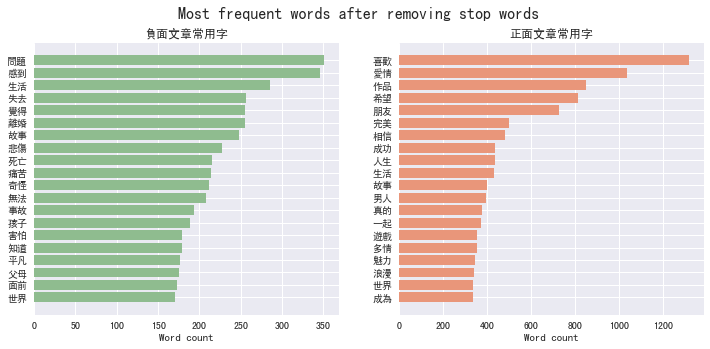

In [25]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(data1['word'],data1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(data2['word'],data2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

### 建立模型
  + 針對兩個response進行建模
  + 版別：分為韓劇、陸劇、台劇
  + 情緒：分為正向、中性、負向情緒

#### 切割資料，將資料七三切

In [27]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data, stratify=data["artCat"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["artCat"].values
y_test = dtf_test["artCat"].values

In [29]:
print(f"raw data percentage :\n{data['artCat'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['artCat'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['artCat'].value_counts(normalize=True) * 100}")

raw data percentage :
KoreaDrama     80.550097
TaiwanDrama    16.914979
China_Drama     2.534924
Name: artCat, dtype: float64

train percentage :
KoreaDrama     80.550050
TaiwanDrama    16.914923
China_Drama     2.535027
Name: artCat, dtype: float64

test percentage :
KoreaDrama     80.550207
TaiwanDrama    16.915107
China_Drama     2.534686
Name: artCat, dtype: float64


In [31]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(train_data)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [32]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

In [33]:
cut_off = 0 
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off )

In [52]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True,cache_size=800,C=0.8)
cla_rf  = ensemble.RandomForestClassifier(max_depth=800)
cla_GB   = GradientBoostingClassifier(random_state=1)
cla_xgb =XGBClassifier(random_state=1,use_label_encoder=True)
cla_catb=CatBoostClassifier(random_state=1)
cla_knn = KNeighborsClassifier(n_neighbors=15)

In [35]:
corpus = dtf_train["clean_txt"]
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [36]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 版別分類
   + 以Accuracy（準確性）作為判斷模型預測力的標準

#### Logistic

model type: CV + logistic regression


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 6.21317195892334
Accuracy: 0.86
Auc: 0.84
Detail:
              precision    recall  f1-score   support

 China_Drama       0.72      0.20      0.32      1277
  KoreaDrama       0.86      0.99      0.92     40582
 TaiwanDrama       0.86      0.36      0.51      8522

    accuracy                           0.86     50381
   macro avg       0.82      0.52      0.58     50381
weighted avg       0.86      0.86      0.84     50381



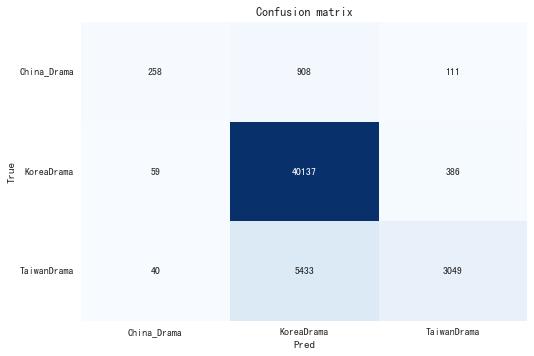

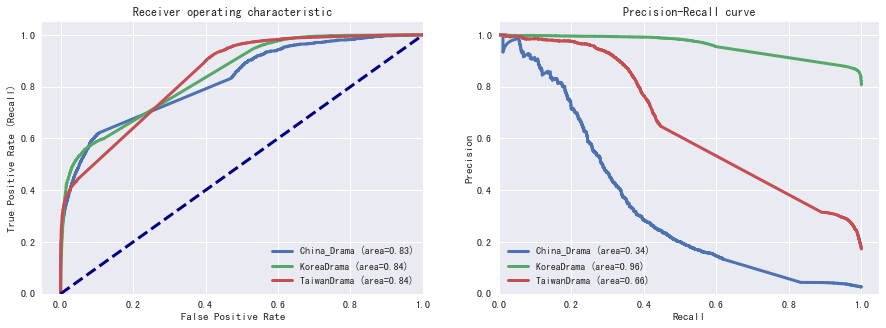

In [60]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，KoreaDrama與TaiwanDrama的預測力最高，為0.84
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有5433筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: TF-IDF + logistic regression


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 6.4299280643463135
Accuracy: 0.86
Auc: 0.84
Detail:
              precision    recall  f1-score   support

 China_Drama       0.90      0.13      0.22      1277
  KoreaDrama       0.86      0.99      0.92     40582
 TaiwanDrama       0.87      0.35      0.50      8522

    accuracy                           0.86     50381
   macro avg       0.88      0.49      0.55     50381
weighted avg       0.86      0.86      0.83     50381



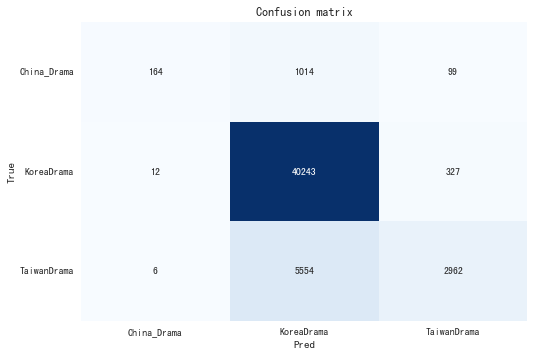

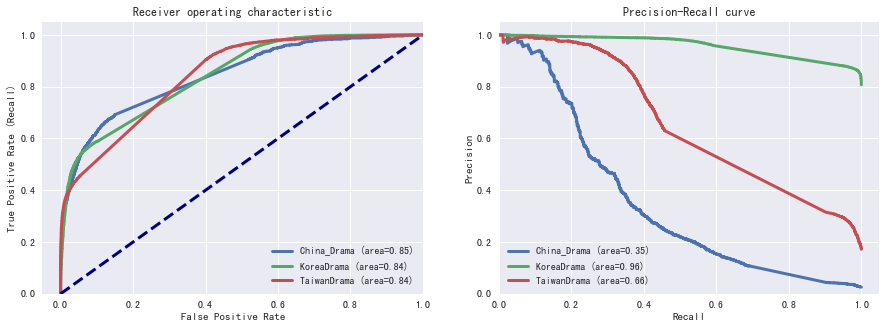

In [38]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，China_Drama的預測力最高，為0.85
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有5554筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

#### SVC

model type: CV + SVC
time costing: 4682.31800699234
Accuracy: 0.85
Auc: 0.75
Detail:
              precision    recall  f1-score   support

 China_Drama       0.94      0.06      0.11      1277
  KoreaDrama       0.85      1.00      0.92     40582
 TaiwanDrama       0.92      0.28      0.43      8522

    accuracy                           0.85     50381
   macro avg       0.90      0.44      0.48     50381
weighted avg       0.86      0.85      0.81     50381



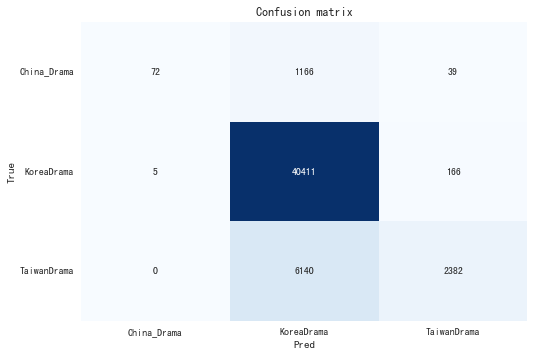

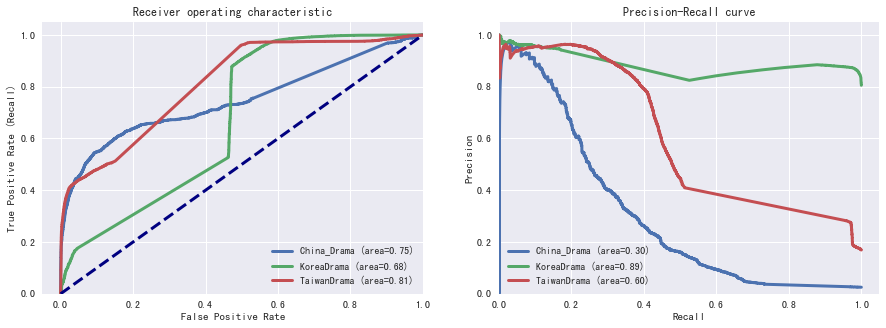

In [39]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，TaiwanDrama的預測力最高，為0.81
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有6140筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: TF-IDF + SVC
time costing: 4379.223897218704
Accuracy: 0.86
Auc: 0.75
Detail:
              precision    recall  f1-score   support

 China_Drama       0.92      0.09      0.16      1277
  KoreaDrama       0.86      0.99      0.92     40582
 TaiwanDrama       0.92      0.33      0.49      8522

    accuracy                           0.86     50381
   macro avg       0.90      0.47      0.52     50381
weighted avg       0.87      0.86      0.83     50381



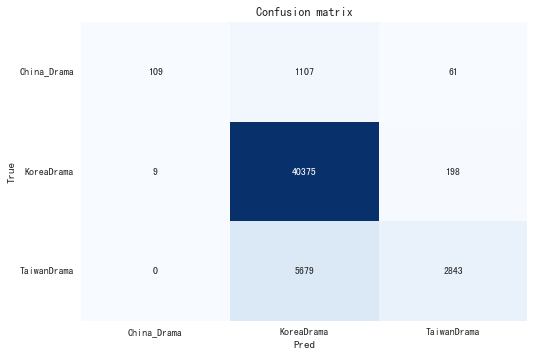

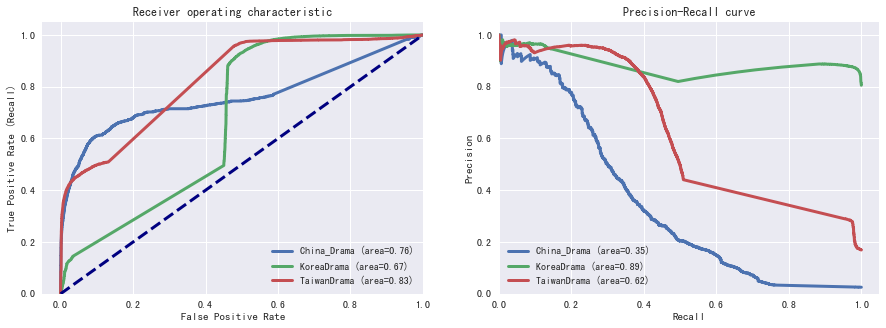

In [40]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，TaiwanDrama的預測力最高，為0.83
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有5679筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

Randomforest

model type: CV + RandomForest
time costing: 80.26862001419067
Accuracy: 0.86
Auc: 0.81
Detail:
              precision    recall  f1-score   support

 China_Drama       0.71      0.17      0.27      1277
  KoreaDrama       0.86      0.99      0.92     40582
 TaiwanDrama       0.85      0.34      0.49      8522

    accuracy                           0.86     50381
   macro avg       0.81      0.50      0.56     50381
weighted avg       0.85      0.86      0.83     50381



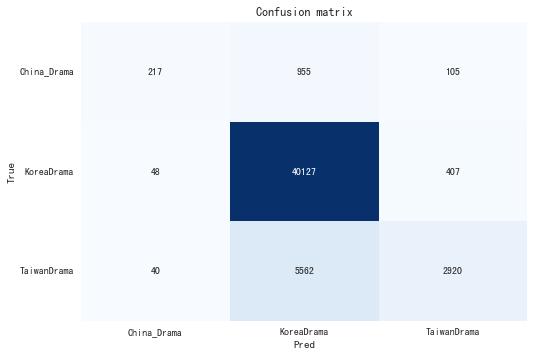

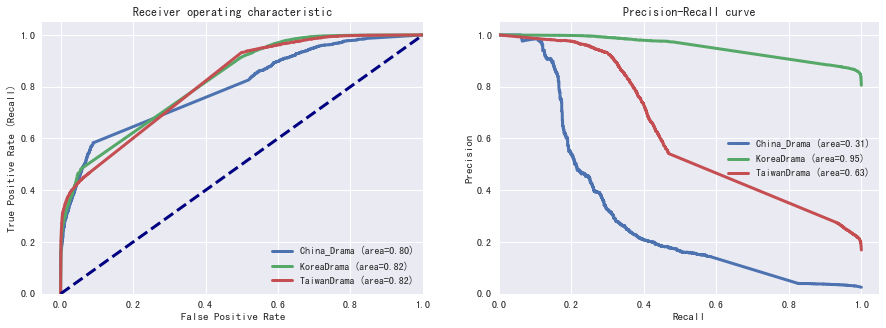

In [41]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，KoreaDrama與TaiwanDrama的預測力最高，為0.82
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有5562筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: TF-IDF + RandomForest
time costing: 80.7038938999176
Accuracy: 0.86
Auc: 0.81
Detail:
              precision    recall  f1-score   support

 China_Drama       0.86      0.16      0.27      1277
  KoreaDrama       0.86      0.99      0.92     40582
 TaiwanDrama       0.88      0.35      0.50      8522

    accuracy                           0.86     50381
   macro avg       0.87      0.50      0.56     50381
weighted avg       0.86      0.86      0.83     50381



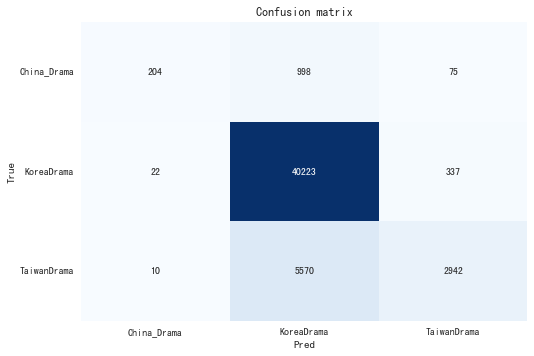

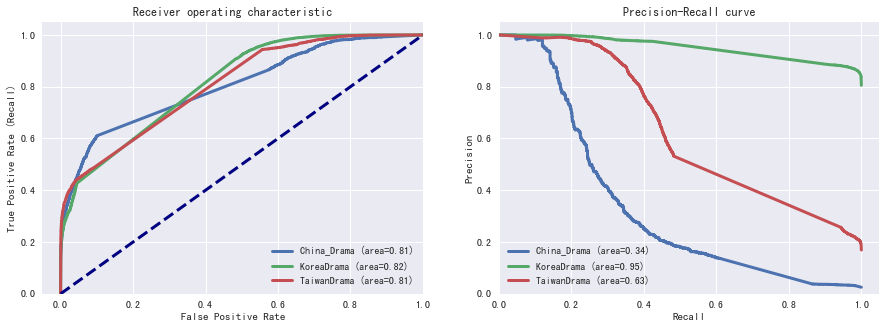

In [42]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，KoreaDrama的預測力最高，為0.82
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有5570筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

Gradient boosting

model type: CV + Gradient boosting
time costing: 16.871402978897095
Accuracy: 0.83
Auc: 0.65
Detail:
              precision    recall  f1-score   support

 China_Drama       0.97      0.10      0.19      1277
  KoreaDrama       0.82      1.00      0.90     40582
 TaiwanDrama       0.93      0.11      0.20      8522

    accuracy                           0.83     50381
   macro avg       0.91      0.41      0.43     50381
weighted avg       0.85      0.83      0.77     50381



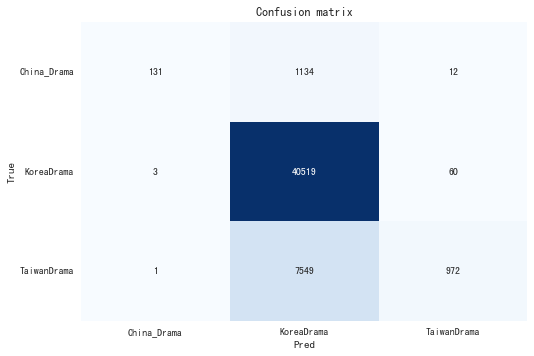

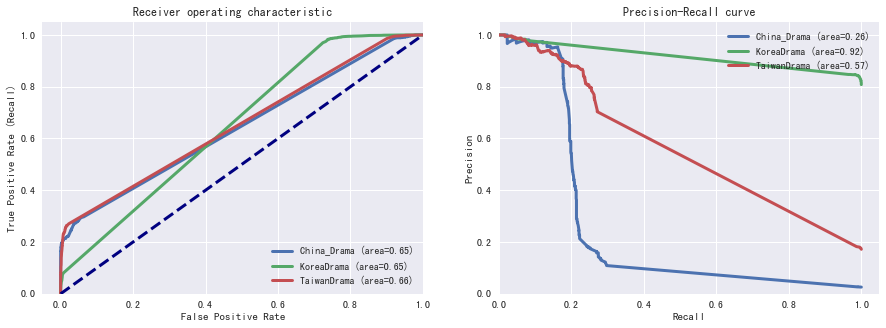

In [43]:
model_type = "CV + Gradient boosting"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_GB
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，TaiwanDrama的預測力最高，為0.66
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有7549筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: TF-IDF+ Gradient boosting
time costing: 25.85657811164856
Accuracy: 0.83
Auc: 0.65
Detail:
              precision    recall  f1-score   support

 China_Drama       0.96      0.10      0.18      1277
  KoreaDrama       0.82      1.00      0.90     40582
 TaiwanDrama       0.94      0.12      0.22      8522

    accuracy                           0.83     50381
   macro avg       0.91      0.41      0.43     50381
weighted avg       0.85      0.83      0.77     50381



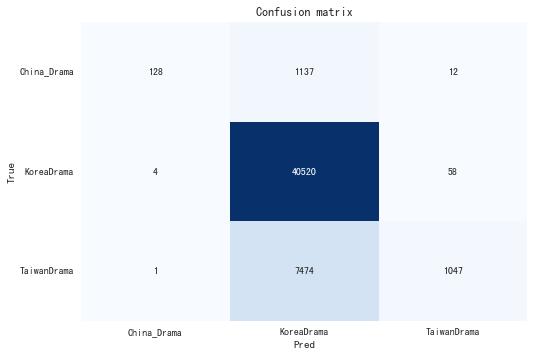

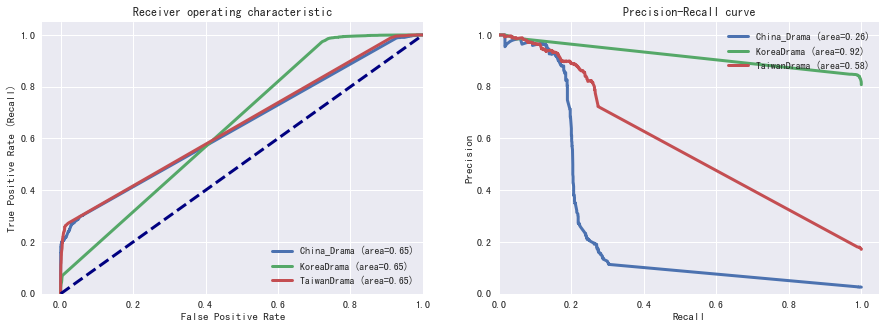

In [44]:
model_type = "TF-IDF+ Gradient boosting"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_tfidf, classifier = cla_GB
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，三者的預測力平均為0.65
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有7474筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

#### Xgboost

model type: CV + XGboosting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
time costing: 6.777734994888306
Accuracy: 0.84
Auc: 0.76
Detail:
              precision    recall  f1-score   support

 China_Drama       0.96      0.12      0.21      1277
  KoreaDrama       0.84      1.00      0.91     40582
 TaiwanDrama       0.93      0.21      0.34      8522

    accuracy                           0.84     50381
   macro avg       0.91      0.44      0.49     50381
weighted avg       0.86      0.84      0.80     50381



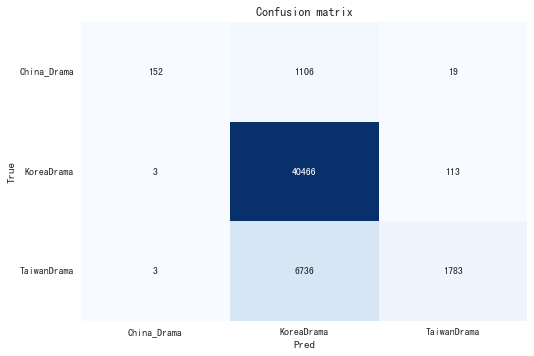

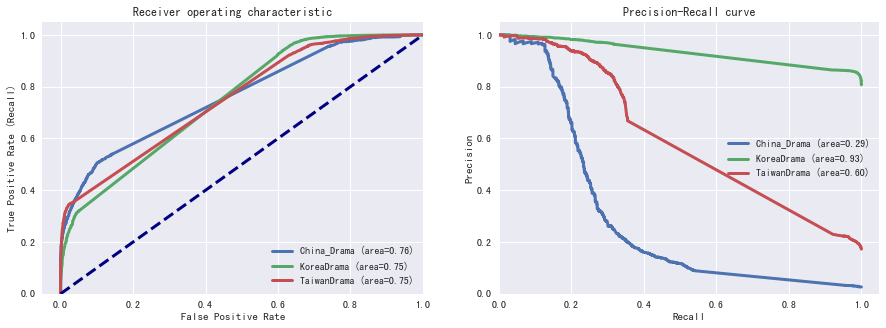

In [45]:
model_type = "CV + XGboosting"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_xgb
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，China_Drama的預測力最高，為0.76
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有6736筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: tfidf + XGboosting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
time costing: 8.749775886535645
Accuracy: 0.84
Auc: 0.75
Detail:
              precision    recall  f1-score   support

 China_Drama       0.94      0.10      0.18      1277
  KoreaDrama       0.84      1.00      0.91     40582
 TaiwanDrama       0.94      0.21      0.34      8522

    accuracy                           0.84     50381
   macro avg       0.91      0.44      0.48     50381
weighted avg       0.86      0.84      0.80     50381



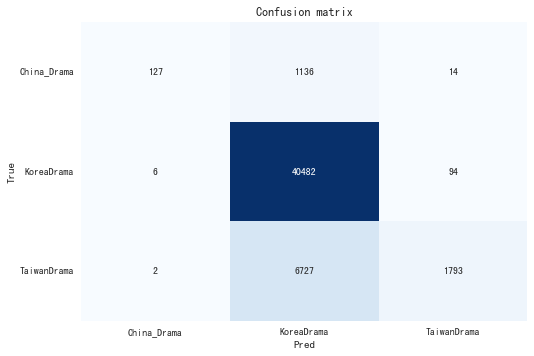

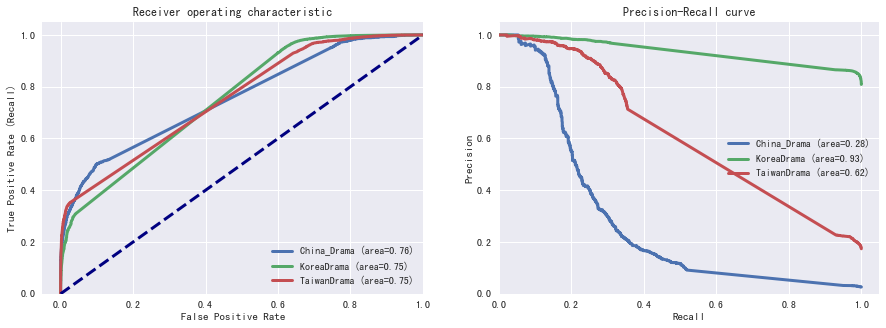

In [46]:
model_type = "tfidf + XGboosting"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_tfidf, classifier = cla_xgb
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，China_Drama的預測力最高，為0.76
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有6727筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

#### Catboost

model type: CV + CatB
Learning rate set to 0.100903
0:	learn: 0.9996236	total: 141ms	remaining: 2m 20s
1:	learn: 0.9238861	total: 181ms	remaining: 1m 30s
2:	learn: 0.8629137	total: 217ms	remaining: 1m 12s
3:	learn: 0.8150096	total: 254ms	remaining: 1m 3s
4:	learn: 0.7759199	total: 290ms	remaining: 57.7s
5:	learn: 0.7423396	total: 328ms	remaining: 54.4s
6:	learn: 0.7147862	total: 363ms	remaining: 51.4s
7:	learn: 0.6917128	total: 395ms	remaining: 49s
8:	learn: 0.6716620	total: 428ms	remaining: 47.1s
9:	learn: 0.6547612	total: 461ms	remaining: 45.6s
10:	learn: 0.6396992	total: 493ms	remaining: 44.3s
11:	learn: 0.6265560	total: 526ms	remaining: 43.3s
12:	learn: 0.6156797	total: 559ms	remaining: 42.4s
13:	learn: 0.6055279	total: 592ms	remaining: 41.7s
14:	learn: 0.5968955	total: 625ms	remaining: 41.1s
15:	learn: 0.5894245	total: 658ms	remaining: 40.5s
16:	learn: 0.5832353	total: 690ms	remaining: 39.9s
17:	learn: 0.5776186	total: 723ms	remaining: 39.4s
18:	learn: 0.5726285	total: 756ms	remai

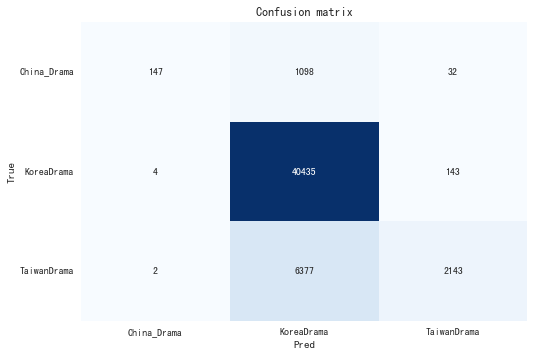

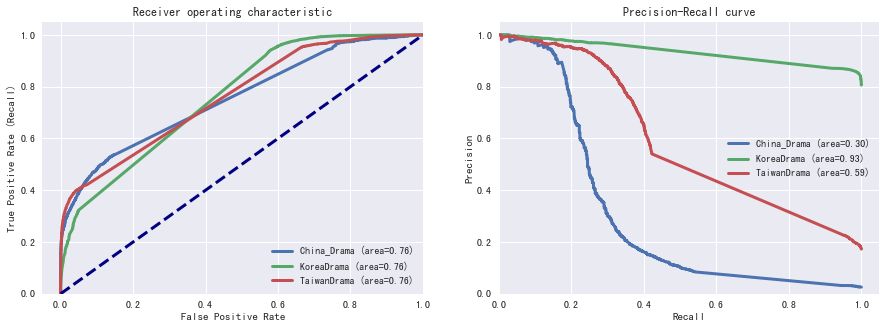

In [47]:
model_type = "CV + CatB"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_catb
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: tfidf + catb
Learning rate set to 0.100903
0:	learn: 0.9978743	total: 126ms	remaining: 2m 5s
1:	learn: 0.9220313	total: 232ms	remaining: 1m 55s
2:	learn: 0.8617368	total: 337ms	remaining: 1m 51s
3:	learn: 0.8127909	total: 444ms	remaining: 1m 50s
4:	learn: 0.7732676	total: 551ms	remaining: 1m 49s
5:	learn: 0.7405940	total: 656ms	remaining: 1m 48s
6:	learn: 0.7129175	total: 765ms	remaining: 1m 48s
7:	learn: 0.6885742	total: 873ms	remaining: 1m 48s
8:	learn: 0.6691464	total: 983ms	remaining: 1m 48s
9:	learn: 0.6521997	total: 1.09s	remaining: 1m 48s
10:	learn: 0.6373908	total: 1.2s	remaining: 1m 48s
11:	learn: 0.6251432	total: 1.31s	remaining: 1m 47s
12:	learn: 0.6138285	total: 1.42s	remaining: 1m 47s
13:	learn: 0.6043546	total: 1.52s	remaining: 1m 47s
14:	learn: 0.5959704	total: 1.63s	remaining: 1m 47s
15:	learn: 0.5887577	total: 1.74s	remaining: 1m 47s
16:	learn: 0.5824501	total: 1.85s	remaining: 1m 47s
17:	learn: 0.5771522	total: 1.96s	remaining: 1m 46s
18:	learn: 0.5721942	

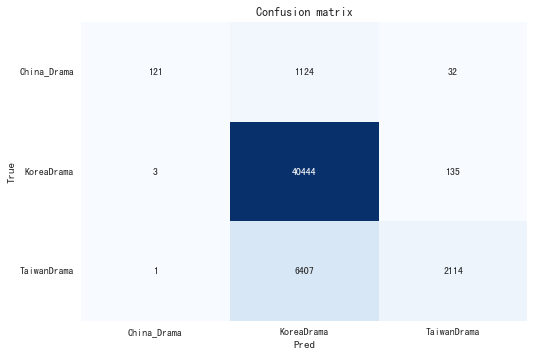

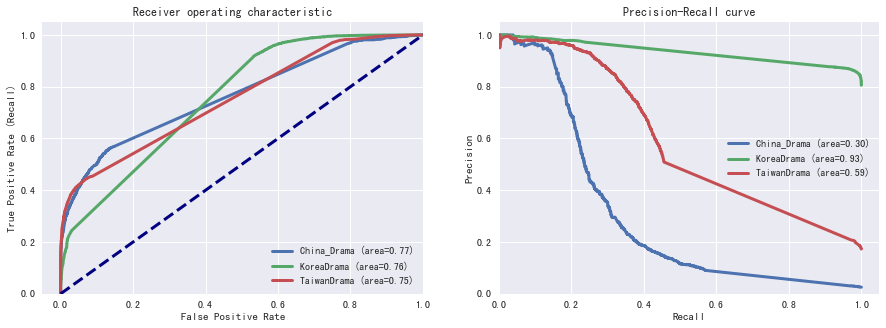

In [48]:
model_type = "tfidf + catb"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_tfidf, classifier = cla_catb
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### knn

model type: cv + knn
time costing: 215.4655900001526
Accuracy: 0.84
Auc: 0.75
Detail:
              precision    recall  f1-score   support

 China_Drama       0.86      0.02      0.04      1277
  KoreaDrama       0.84      0.99      0.91     40582
 TaiwanDrama       0.84      0.24      0.37      8522

    accuracy                           0.84     50381
   macro avg       0.85      0.42      0.44     50381
weighted avg       0.84      0.84      0.80     50381



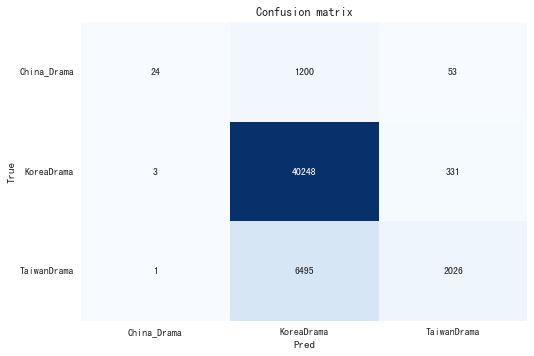

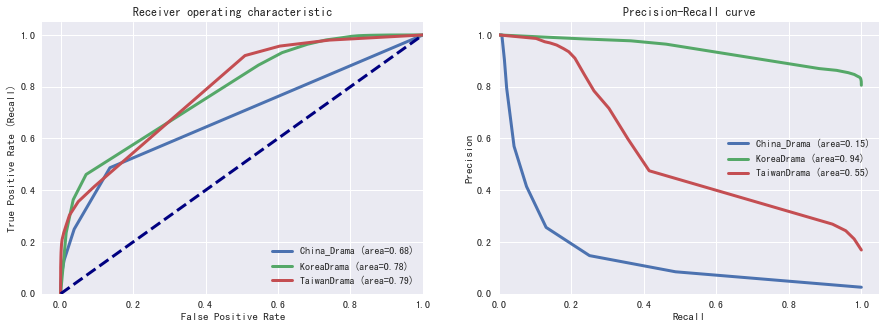

In [53]:
model_type = "cv + knn"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_knn
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，TaiwanDrama的預測力最高，為0.79
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有6495筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

model type: tfidf + knn
time costing: 215.1343071460724
Accuracy: 0.84
Auc: 0.75
Detail:
              precision    recall  f1-score   support

 China_Drama       0.80      0.04      0.07      1277
  KoreaDrama       0.84      0.99      0.91     40582
 TaiwanDrama       0.88      0.23      0.37      8522

    accuracy                           0.84     50381
   macro avg       0.84      0.42      0.45     50381
weighted avg       0.85      0.84      0.80     50381



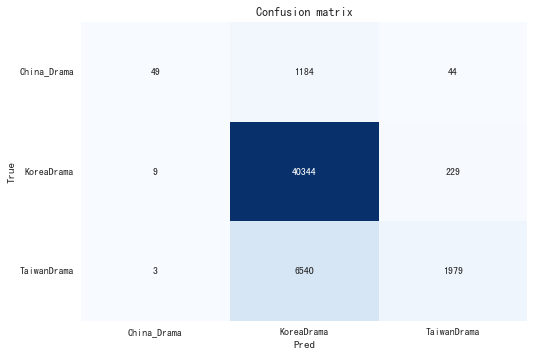

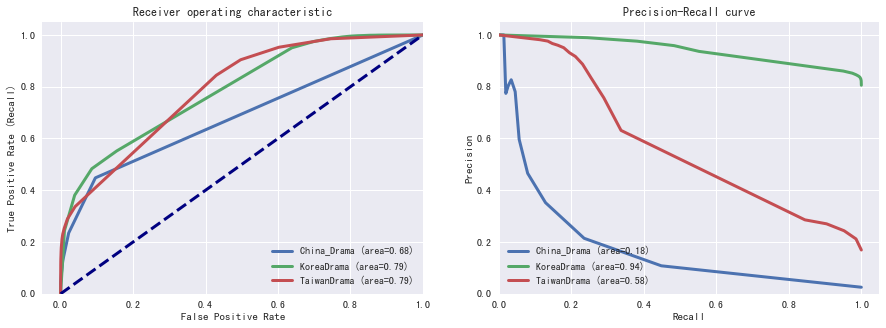

In [54]:
model_type = "tfidf + knn"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_tfidf, classifier = cla_knn
                                 )
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

+ 在Receiver operating characteristic中，KoreaDrama與TaiwanDrama的預測力最高，為0.79
+ 從precision來看主要是chinadrama的分類最不理想，而taiwandrama也存在一些問題
+ 從Matrix矩陣來看，我們可以發現預測為KoreaDrama跟事實卻為的TaiwanDrama的有6540筆，與常見的分佈有些不同，可以再透過後續的查看分錯句子來加強準確度。

In [55]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
0,CV + logistic regression,0.862309,0.837646
1,TF-IDF + logistic regression,0.860821,0.844584
5,TF-IDF + RandomForest,0.860821,0.809696
3,TF-IDF + SVC,0.859987,0.753845
4,CV + RandomForest,0.858736,0.812501
2,CV + SVC,0.850817,0.745895
10,CV + CatB,0.848038,0.760348
11,tfidf + catb,0.847125,0.758798
9,tfidf + XGboosting,0.841627,0.754139
8,CV + XGboosting,0.841607,0.755158


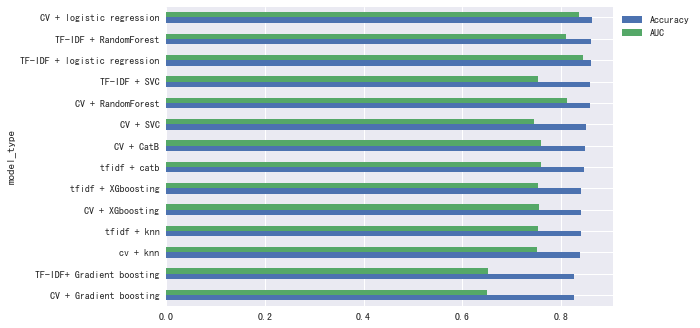

In [56]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend() #顯示圖例
plt.legend(bbox_to_anchor=(1,1))

可以看出效果最好的組合是CV，加上logistic regression的模型。

In [57]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [61]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,China_Drama,KoreaDrama,TaiwanDrama
一下,0.568786,-0.078282,-0.144626
一下半,-0.095603,-0.144131,0.890657
一下子,-0.233843,0.442066,0.135477
一不小心,0.592319,-0.046396,0.797147
一二,0.339963,0.026493,0.354542
一些,-0.386152,0.160729,-0.187034
一人,-0.111651,-0.154135,0.914149
一件,-0.155124,-0.245223,0.372852
一份,0.126180,0.797446,1.105152
一位,-0.163551,-0.013917,0.301164


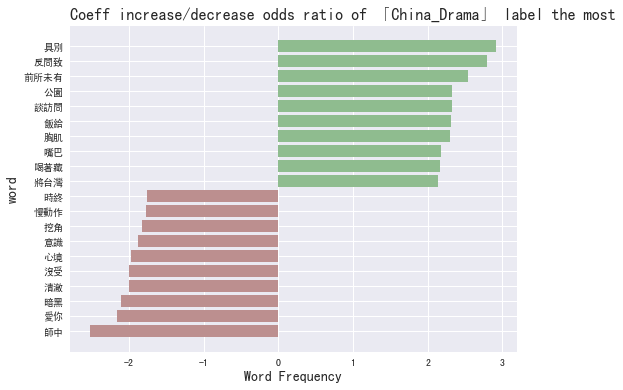

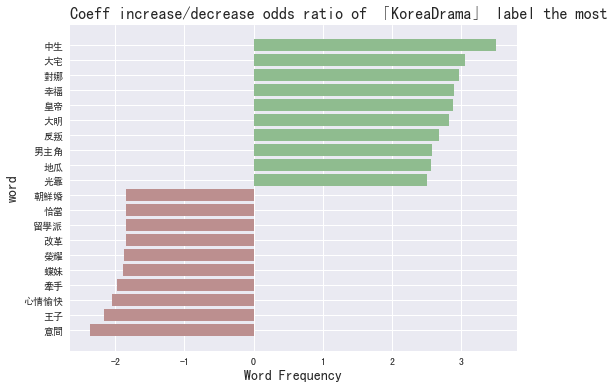

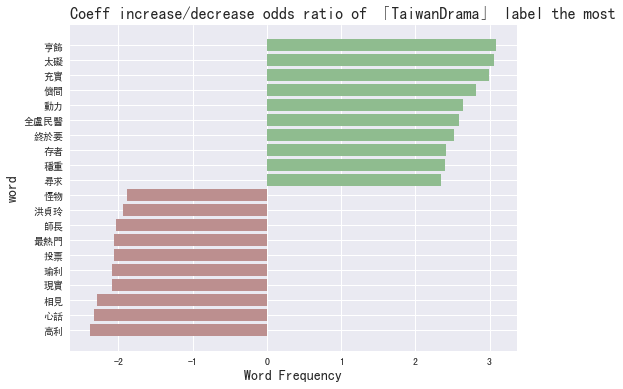

In [62]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

「前所未有」是影響是否被判對為陸劇的重要字詞；「大明」（指得是韓國朝代）、「反叛」是影響判斷是否為韓劇的重要字詞，有可能是針對韓國歷史古裝劇進行分類；「動力」、「充實」是影響是否被判斷為台劇的重要字詞。

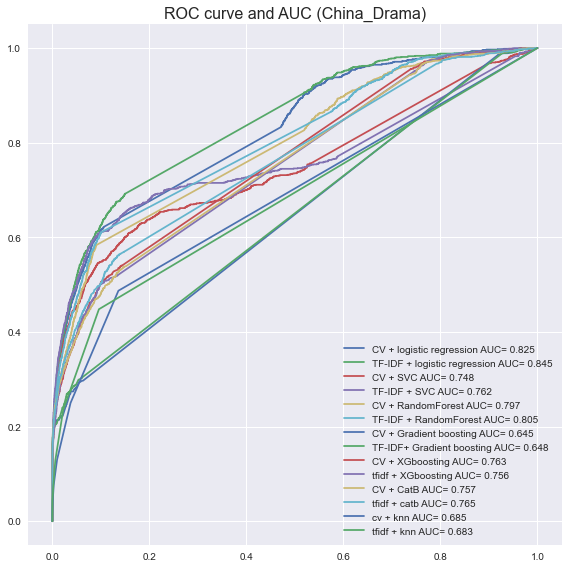

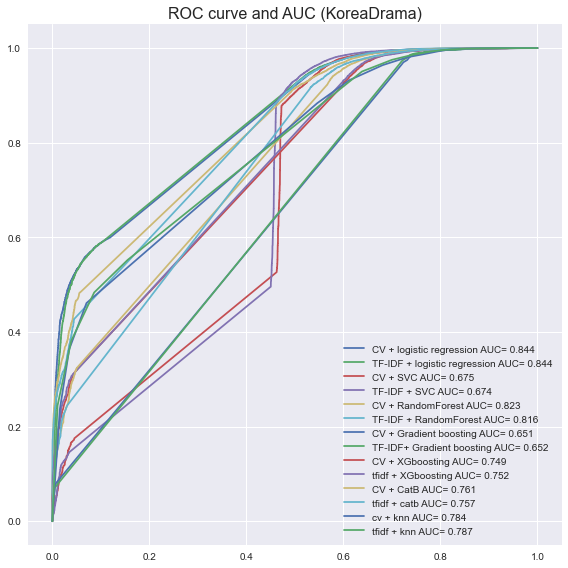

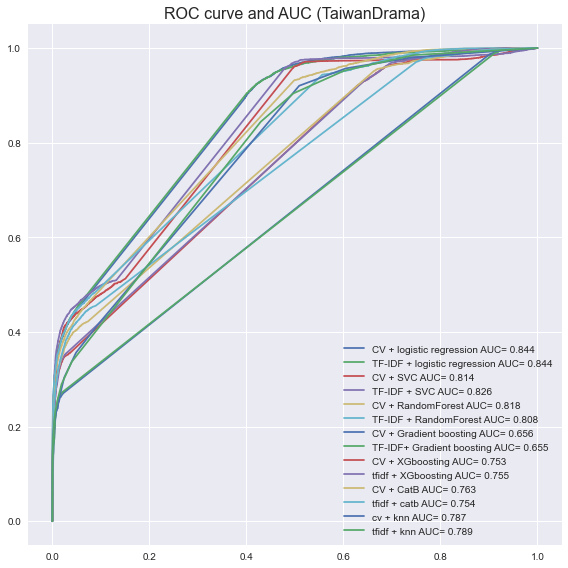

In [63]:
plt.style.use('seaborn')    

l = ['China_Drama','KoreaDrama','TaiwanDrama']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

由上方三個總體預測模型來看，我們可以看出每個版別的預測力分佈：
+ 以ChinaDrma ROC curve and AUC來看，TF-IDF+logistic regression預測力最高0.845
+ 以KoreaDrama ROC curve and AUC來看，CV+logistic regression以及TF-IDF+logistic regression預測力最高0.844
+ 以TaiwanDrama ROC curve and AUC來看，CV+logistic regression以及TF-IDF+logistic regression預測力最高0.844

#### 查看分錯的句子

In [64]:
dtf_test['predict'] = pred
China_Drama_wrong = dtf_test.loc[(dtf_test['artCat'] != dtf_test['predict']) & (dtf_test['artCat'] == 'China_Drama')] # 正面句子分錯
KoreaDrama_wrong = dtf_test.loc[(dtf_test['artCat'] != dtf_test['predict']) & (dtf_test['artCat'] == 'KoreaDrama')] # 負面句子分錯
TaiwanDrama_wrong = dtf_test.loc[(dtf_test['artCat'] != dtf_test['predict']) & (dtf_test['artCat'] == 'TaiwanDrama')] # 中性句子分錯

print(f"pos label predicted wrong: {China_Drama_wrong.shape[0]}")
print(f"neg label predicted wrong: {KoreaDrama_wrong.shape[0]}")
print(f"neu label predicted wrong: {TaiwanDrama_wrong.shape[0]}")

pos label predicted wrong: 1073
neg label predicted wrong: 359
neu label predicted wrong: 5580


可以看出ChinaDrama有1073則句子分錯；KoreaDrama有359則句子分錯；TaiwanDrama有5580則句子分錯。

In [65]:
# 陸劇句子分錯
China_Drama_wrong[['sentence','artUrl','artCat','predict']].head(5)

,sentence,artUrl,artCat,predict
10,Netflix上線，每集請來不同大咖嘉賓，包括蕭敬騰、林俊傑、謝霆鋒等人，走訪不同國,https://www.ptt.cc/bbs/China-Drama/M.158589736...,China_Drama,KoreaDrama
27,）,https://www.ptt.cc/bbs/China-Drama/M.161207249...,China_Drama,KoreaDrama
44,子舒的背影也來了～,https://www.ptt.cc/bbs/China-Drama/M.162295153...,China_Drama,KoreaDrama
51,更何況是弟弟！,https://www.ptt.cc/bbs/China-Drama/M.162553731...,China_Drama,KoreaDrama
50,喜歡甜寵劇，最好是HE。,https://www.ptt.cc/bbs/China-Drama/M.162505690...,China_Drama,KoreaDrama


In [66]:
# 韓國句子分錯
KoreaDrama_wrong[['sentence','artUrl','artCat','predict']].head(5)

,sentence,artUrl,artCat,predict
393,呼應 2020 年台灣影視能量大爆發，其中《誰是被害者》與《女鬼橋》躍升為今年最受海,https://www.ptt.cc/bbs/KoreaDrama/M.1607573442...,KoreaDrama,TaiwanDrama
850,巨額獎金，17日在全球上架後廣獲好評，近日更成為點擊數最高的一套影集。,https://www.ptt.cc/bbs/KoreaDrama/M.1632560013...,KoreaDrama,TaiwanDrama
876,去年他在tvN電視劇《惡之,https://www.ptt.cc/bbs/KoreaDrama/M.1633404669...,KoreaDrama,TaiwanDrama
121,堪稱本劇的最佳註解，電影海報片名下的那行小字。,https://www.ptt.cc/bbs/KoreaDrama/M.1583729972...,KoreaDrama,TaiwanDrama
816,"總之，我漸漸覺得所謂""好看""的台劇都長成某幾種特定的樣子，",https://www.ptt.cc/bbs/KoreaDrama/M.1631445281...,KoreaDrama,TaiwanDrama


In [67]:
# 台灣句子分錯
TaiwanDrama_wrong[['sentence','artUrl','artCat','predict']].head(5)

,sentence,artUrl,artCat,predict
1246,▃,https://www.ptt.cc/bbs/TaiwanDrama/M.163741449...,TaiwanDrama,KoreaDrama
1243,到了最後因為其他線都有算是美好的收尾，讓我以為女主角到最後就是過著偶爾想起男主角的生活，頂多...,https://www.ptt.cc/bbs/TaiwanDrama/M.163734399...,TaiwanDrama,KoreaDrama
1120,主演。,https://www.ptt.cc/bbs/TaiwanDrama/M.161192709...,TaiwanDrama,KoreaDrama
1160,▄,https://www.ptt.cc/bbs/TaiwanDrama/M.161981657...,TaiwanDrama,KoreaDrama
1150,https://www.touchttv.com/touchttv/liveTTVplay....,https://www.ptt.cc/bbs/TaiwanDrama/M.161572733...,TaiwanDrama,KoreaDrama


### 情緒分類

In [72]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["sentiments"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["sentiments"].values
y_test = dtf_test["sentiments"].values

In [73]:
print(f"raw data percentage :\n{data_senti['sentiments'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['sentiments'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['sentiments'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    81.209880
pos    12.391773
neg     6.398347
Name: sentiments, dtype: float64

train percentage :
neu    81.210178
pos    12.391857
neg     6.397965
Name: sentiments, dtype: float64

test percentage :
neu    81.209186
pos    12.391576
neg     6.399238
Name: sentiments, dtype: float64


In [74]:
corpus = dtf_train["clean_txt"]
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [75]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

以Accuracy作為分類標準

#### Logistic

model type: CV + logistic regression


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 6.26587986946106
Accuracy: 0.99
Auc: 0.99
Detail:
              precision    recall  f1-score   support

         neg       0.99      0.90      0.94      3224
         neu       0.99      1.00      0.99     40914
         pos       1.00      0.96      0.98      6243

    accuracy                           0.99     50381
   macro avg       0.99      0.95      0.97     50381
weighted avg       0.99      0.99      0.99     50381



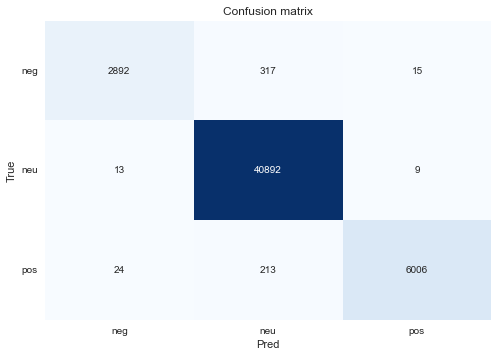

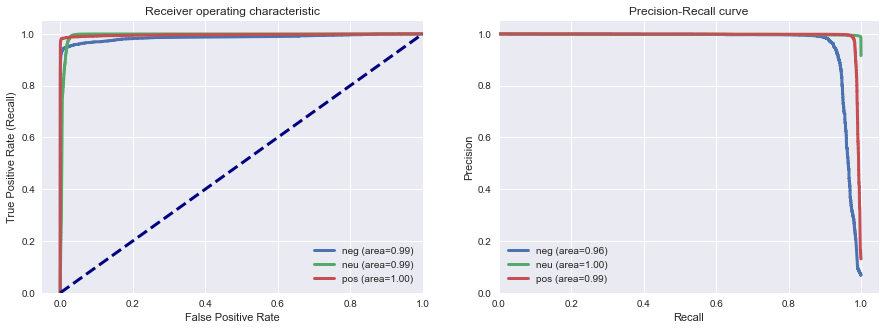

In [76]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

我們可以得知情緒面預測模型在兩者預測模型中皆有蠻高的預測度。

model type: TF-IDF + logistic regression


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 6.246186971664429
Accuracy: 0.98
Auc: 0.99
Detail:
              precision    recall  f1-score   support

         neg       0.99      0.85      0.91      3224
         neu       0.98      1.00      0.99     40914
         pos       1.00      0.93      0.96      6243

    accuracy                           0.98     50381
   macro avg       0.99      0.92      0.95     50381
weighted avg       0.98      0.98      0.98     50381



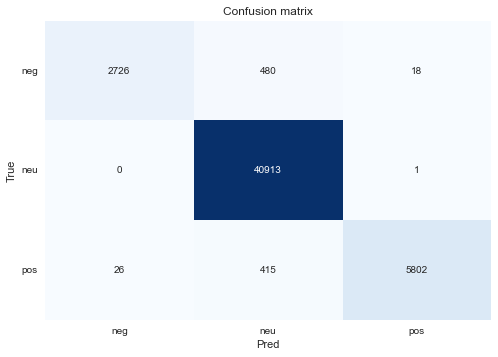

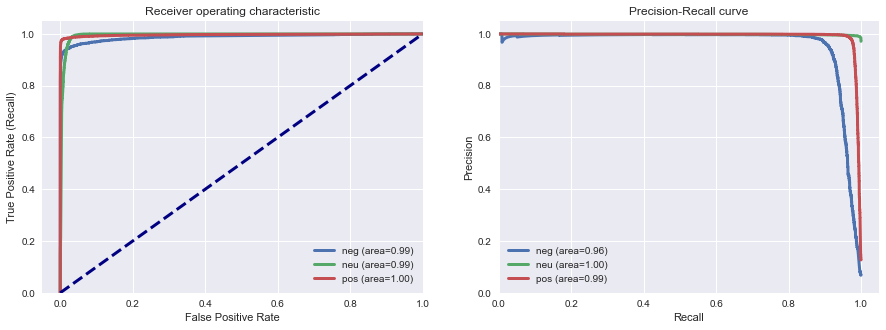

In [77]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

RandomForest

model type: CV + RandomForest
time costing: 67.31522703170776
Accuracy: 0.99
Auc: 0.99
Detail:
              precision    recall  f1-score   support

         neg       0.98      0.93      0.95      3224
         neu       0.99      1.00      1.00     40914
         pos       1.00      0.97      0.98      6243

    accuracy                           0.99     50381
   macro avg       0.99      0.97      0.98     50381
weighted avg       0.99      0.99      0.99     50381



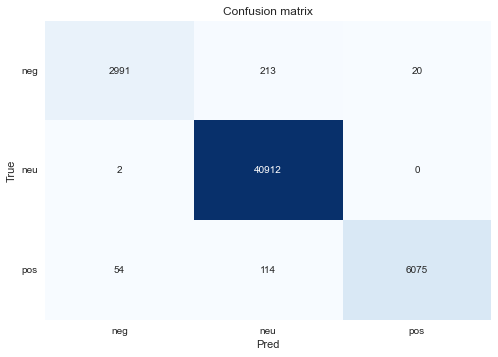

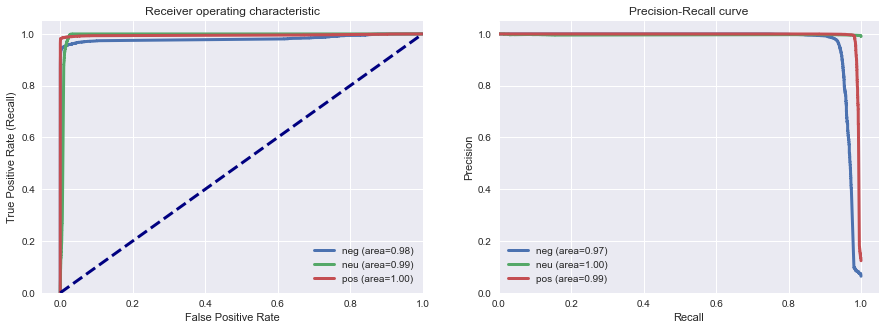

In [78]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 61.93225812911987
Accuracy: 0.99
Auc: 0.99
Detail:
              precision    recall  f1-score   support

         neg       0.98      0.93      0.95      3224
         neu       0.99      1.00      1.00     40914
         pos       1.00      0.97      0.98      6243

    accuracy                           0.99     50381
   macro avg       0.99      0.97      0.98     50381
weighted avg       0.99      0.99      0.99     50381



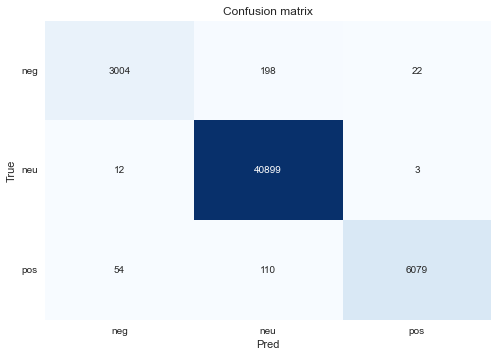

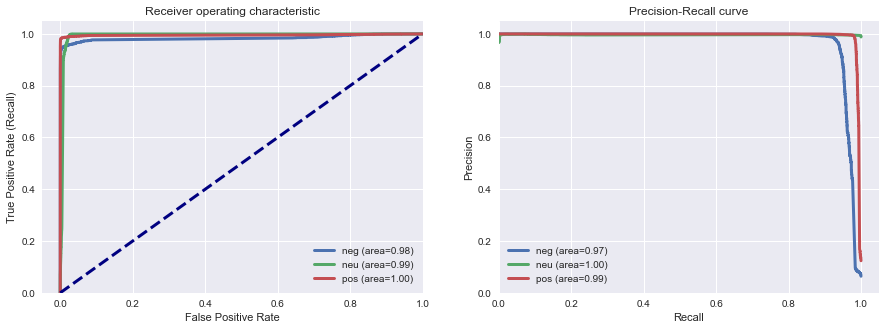

In [79]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [80]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
3,TF-IDF + RandomForest,0.992080,0.991226
2,CV + RandomForest,0.992001,0.990008
0,CV + logistic regression,0.988269,0.992444
1,TF-IDF + logistic regression,0.981342,0.993346


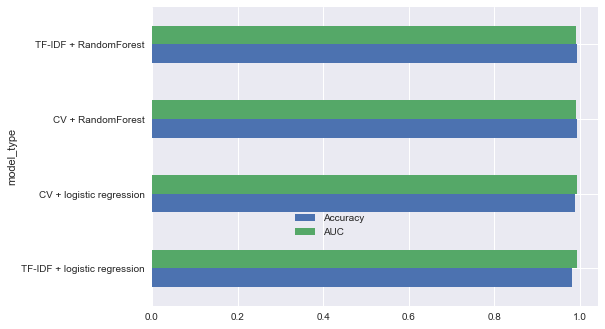

In [81]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

可以看出效果最好的組合是TF-IDF，加上RamdomForest的模型。

In [83]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,neg,neu,pos
一一,-0.074422,-0.013732,0.866542
一三,0.814444,-0.184463,0.367204
一下,-0.135789,0.541152,0.019601
一下子,0.272339,-0.035081,-0.102506
一不小心,-0.121967,-0.116622,-0.060036


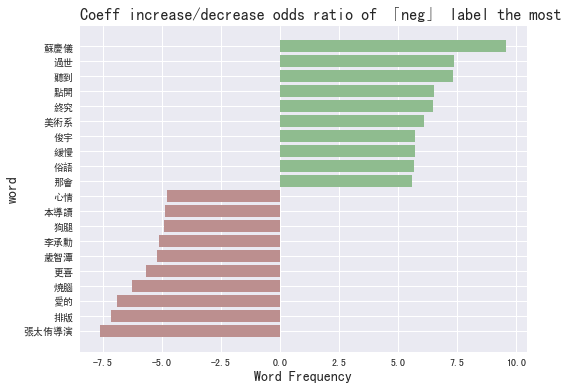

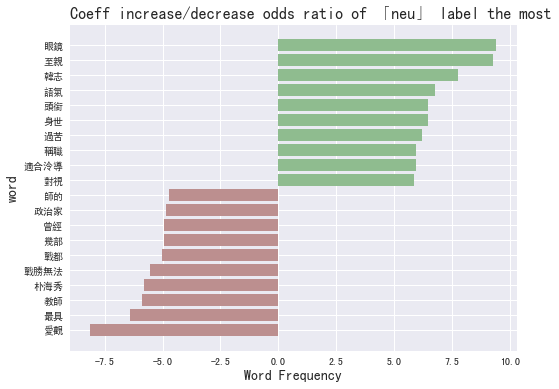

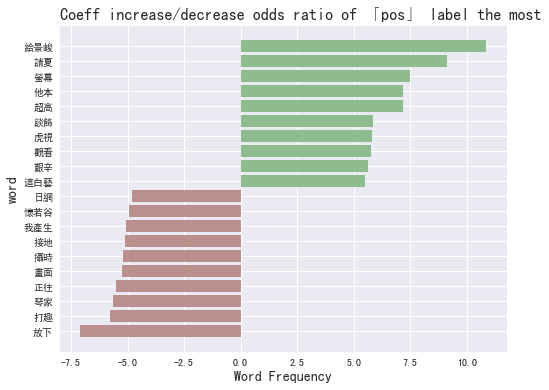

In [84]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

「過世」、「傲慢」是影響是否被判對為負向的重要字詞；「稱職」是影響判斷是否為中性重要字詞；「高超」是否被判斷為正面的重要字詞。

#### 查看分錯的句子

In [85]:
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['sentiments'] != dtf_test['predict']) & (dtf_test['sentiments'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['sentiments'] != dtf_test['predict']) & (dtf_test['sentiments'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['sentiments'] != dtf_test['predict']) & (dtf_test['sentiments'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 164
neg label predicted wrong: 220
neu label predicted wrong: 15


In [86]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','sentiments','predict']].head(5)

,sentence,artUrl,sentiments,predict
145117,走過一路上的顛簸和纏綿,https://www.ptt.cc/bbs/TaiwanDrama/M.160619145...,pos,neu
3482,於心」的諾言並且身體力行的宣言。,https://www.ptt.cc/bbs/China-Drama/M.162505690...,pos,neu
165635,puraurora: 聽著琴聲傻笑的文貴真可愛,https://www.ptt.cc/bbs/TaiwanDrama/M.163741155...,pos,neu
140842,《妖怪人間》的預告吸引觀眾眼球，妖怪化作人形，主角們介於妖怪與人之間糾葛，奇幻,https://www.ptt.cc/bbs/TaiwanDrama/M.158563507...,pos,neu
158380,經由歷史事件的衝突，才能得到和諧。,https://www.ptt.cc/bbs/TaiwanDrama/M.162861200...,pos,neg


In [87]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','sentiments','predict']].head(5)

,sentence,artUrl,sentiments,predict
70638,寡婦、有夫之婦或是妓女，要選單身的小姐(處女)，後來衍變成—— 一樣價錢，當然要,https://www.ptt.cc/bbs/KoreaDrama/M.1609921923...,neg,neu
149358,不適缺席，大家不禁感嘆：「健康債也是無形債務。,https://www.ptt.cc/bbs/TaiwanDrama/M.160930438...,neg,pos
115246,忘了在哪部對他的刀疤印象深刻，一看到就想趕快大叫「英媛啊～快逃啊～」,https://www.ptt.cc/bbs/KoreaDrama/M.1629304306...,neg,neu
121788,記得「火神的眼淚」第一集中就有民眾態度惡劣指導消防員救火的場景，看著的時候，我,https://www.ptt.cc/bbs/KoreaDrama/M.1631445281...,neg,neu
16667,導演常常會倒敘或用補敘的方式來呈現，這點倒是沒困擾到我，,https://www.ptt.cc/bbs/KoreaDrama/M.1585378792...,neg,neu


In [88]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','sentiments','predict']].head(5)

,sentence,artUrl,sentiments,predict
95763,上樓下，你的對手是個整天在棋院，走路還睜不開眼睛看路的人內，讓我感到最對比的是,https://www.ptt.cc/bbs/KoreaDrama/M.1623119721...,neu,neg
132335,這些導致了魷魚遊戲一上映就在各大討論區洗版,https://www.ptt.cc/bbs/KoreaDrama/M.1634491799...,neu,neg
147103,子彤的跆拳夢雖然終結，但,https://www.ptt.cc/bbs/TaiwanDrama/M.160898858...,neu,neg
127945,[新聞]魷魚遊戲》導致流量暴增南韓電信商控告《魷魚遊戲》導致流量暴增 南韓電信商控告Netf...,https://www.ptt.cc/bbs/KoreaDrama/M.1633162189...,neu,neg
127422,但經過第一關遊戲的「血腥震撼」之後，許多人臨陣退縮了，原本想投票棄權的 212 號,https://www.ptt.cc/bbs/KoreaDrama/M.1632895334...,neu,neg


## 結論
1.從版別的分類模型來看，可以得出效果最好的組合是CV，加上logistic regression的模型。<br>
2.從情緒的分類模型來看，可以得出效果最好的組合是是TF-IDF，加上RamdomForest的模型。<br>